# Úkol č. 1 - redukce dimenzionality a binární klasifikace

  * **Deadline je do 8. 5. 2023, 23:59:59**, pokud odevzdáte úkol do 14. 5. 2023, 23:59:59, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu se musíte vypořádat s vysokou dimenzí problému a poté úspěšně aplikovat vhodný klasfikační model.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 28x28 pixelů ve stupních šedi, které byly získány z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Postupně aplikujte modely **SVM**, **naivní Bayesův klasifikátor** a **LDA**, přičemž pro každý z nich:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Vyberte si hlavní hyperparametry k ladění (pokud model má hyperparametry) a najděte jejich nejlepší hodnoty.
      * Experimentujte se standardizací/normalizací dat.
      * U SVM vyzkoušejte alespoň dvě různé jádrové funkce.
      * Získané výsledky vždy řádně okomentujte.


  * Postupně aplikujte metody redukce dimenzionality PCA a LLE, přičemž pro každou z nich: 
      * Zopakujte předchozí kroky a pokuste modely vylepšit
      * Zkoumejte jaká dimenze je z hlediska výkonnosti finálního modelu nejlepší.
      * Získané výsledky vždy řádně okomentujte.
    
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru `evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **predikce labelu**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

##### Imports/defines

In [211]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Normalizer, FunctionTransformer, StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from joblib import Memory

import matplotlib.pyplot as plt
%matplotlib inline

cachedir = './cache'
memory = Memory(location=cachedir, verbose=0)
accuracy = {
    'SVM': {'def': 0,
            'tuned': 0,
            'normalized': 0,
            'PCA': 0,
            'LLE': 0},

    'NB': {'def': 0,
           'tuned': 0,
           'normalized': 0,
           'PCA': 0,
           'LLE': 0},

    'LDA': {'def': 0,
            'tuned': 0,
            'normalized': 0,
            'PCA': 0,
            'LLE': 0}
}


def suffix(num):
    return 'st' if num == 1 else 'nd' if num == 2 else 'rd' if num == 3 else 'th'


##### Prvním nahlédnutí na data 

In [212]:
df = pd.read_csv("train.csv")
display(df.head())
print(f"null entries: {df.isnull().sum().any()}\n")
display(df.info())
display(df.describe())


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,1,2,1,4,2,0,0,...,37,73,65,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,105,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,135,135,184,59,0,2,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,70,0,0,0,0,0,0,0,0,0


null entries: False

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 14.4 MB


None

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.500417,0.000417,0.002917,0.066667,0.144583,0.216667,0.462917,1.605833,4.184167,10.954167,...,78.508750,49.705417,34.747083,14.742500,3.866667,1.334167,0.341250,0.141250,0.036250,0.006667
std,0.500104,0.020412,0.053939,0.688539,2.762431,2.343682,4.989054,12.574764,21.183025,33.693930,...,66.539823,62.185924,56.259061,37.883132,18.662614,10.515159,4.338699,3.205685,0.930661,0.287211
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,74.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,129.000000,92.250000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,30.000000,132.000000,85.000000,172.000000,189.000000,255.000000,227.000000,...,248.000000,247.000000,241.000000,244.000000,215.000000,184.000000,116.000000,106.000000,31.000000,14.000000


Zde můžeme rovnou vidět, že některé pixely budou důležitější než jiné. Například ty na kraji mají průměrnou hodnotu blízkou nule nebo na a jejich maximum je jedna. To značí, že tam je černo a tudíž jsme mimo oblečení. Pixely budou mít průměrnou hodnotu mnohem vyšší a maximum bude dosahovat až na 255 (bílá) a tudíž budou v modelu hrát větší roli.

In [213]:
things = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress",
          4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
print(f"unique labels: {df['label'].unique()}\n")
for i in things:
    print(f"{things[i]}  {df[df['label'] == i].shape[0]}")


unique labels: [1 0]

T-shirt/top  1199
Trouser  1201
Pullover  0
Dress  0
Coat  0
Sandal  0
Shirt  0
Sneaker  0
Bag  0
Ankle boot  0


Vidíme že:
* v datasetu nejsou žádné null hodnoty
* dataset obsahuje 784 sloupců, cožodpovídá všem 28*28 pixelů, kde každý odpovídá hodnotě 0-255 (černá-bílá), a jeden sloupec pro label
* z původních 10 možných labels je dataset osekán jen na trička a kalhoty. Jsou zastoupeny skoro v poměru 1:1

##### Rozdělení datasetu na trénovací a testovací množinu

In [214]:
ydata = df["label"]
Xdata = df.drop("label", axis=1)


Jelikož používám pipelines společně s GridSearchCV, které používají již v sobě zabudovanou cross-validaci, vystačím si jen s trénovací a testovací množinou 

In [215]:
Xtrain, Xtest, ytrain, ytest = train_test_split(
    Xdata, ydata, test_size=0.3, random_state=666)

print(f"Train dimension, X: {Xtrain.shape}, y: {ytrain.shape}")
print(f"Test dimension, X: {Xtest.shape}, y: {ytest.shape}")


Train dimension, X: (1680, 784), y: (1680,)
Test dimension, X: (720, 784), y: (720,)


##### Zobrazení obrázků z trénovací množiny

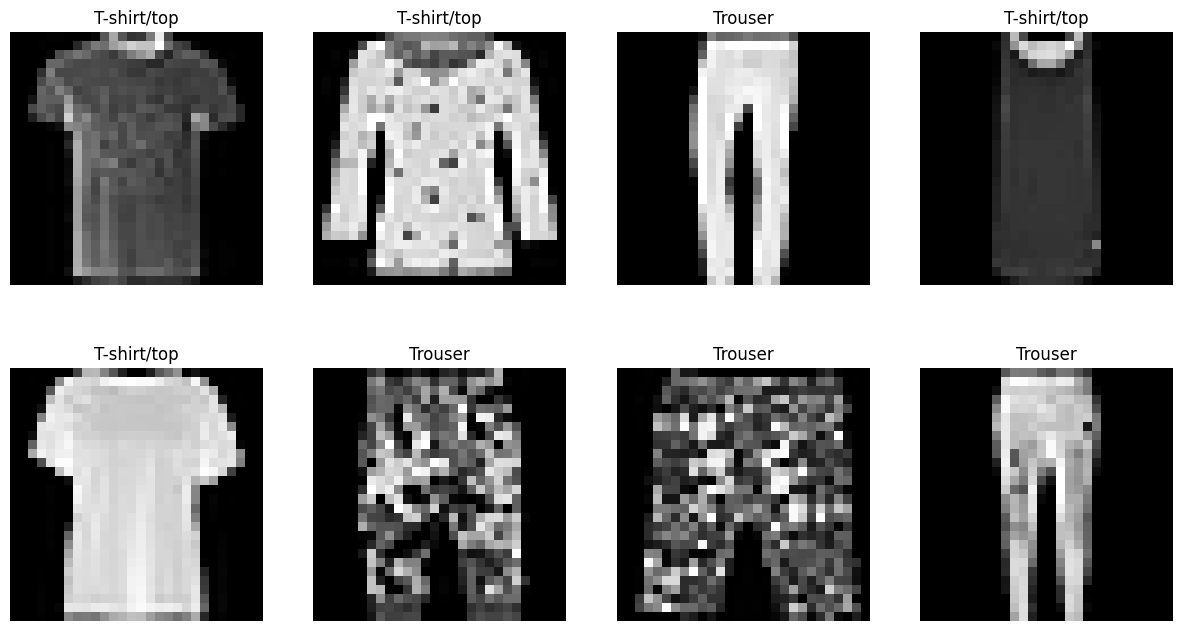

In [216]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(Xtrain.iloc[i].values.reshape((28, 28)), cmap='gray')
    ax.axis('off')
    ax.set_title(things[ytrain.iloc[i]])


Vidíme, že se opravdu jedná o trička a kalhoty (dejme tomu). Na každém obrázku je minimálně čtvrtina pixelů, které jsou jen pozadí a přináší tak minimální informaci o tom, jaké oblečení je na obrázku.

## Bez redukce dimenze

### Bez normalizace

#### SVM
* rozdělujeme jen na dvě kategorie, které by měli být dobře separovatelné. SVM navíc nemá problém s vysokou dimenzí a povede tedy k velmi dobrý výsledkům již před redukcí dimenze

##### Defaultní hyperparametry
* zde jen vyzkouším, jak dobrých výsledků dosáhne metoda SVC bez ladění hyperparametrů s defaultními hodnotami

In [217]:
svc_pipe = make_pipeline(SVC(), memory=memory)
_ = svc_pipe.fit(Xtrain, ytrain)
print(f'accuracy score (train): {svc_pipe.score(Xtrain, ytrain):.4f}')


accuracy score (train): 0.9911


Jak můžeme vidět, model si s daty poradil vskutku bravurně a již takto má velmi dobrou přesnost

##### Ladění
* Základní model je velmi dobrý, přesto se ho pokusím ještě o fous zlepšit


Zkusím měnit penalizaci C a jádrové funkce

In [218]:
svc_param_grid = {
    'svc__C': [*map(lambda x: x/10.0, range(10, 20, 1)), *map(lambda x: x/10.0, range(20, 35, 5)), 10, 100],
    'svc__kernel': ['linear', 'poly', 'rbf']
}


In [219]:
gs_svc = GridSearchCV(svc_pipe,
                      param_grid=svc_param_grid,
                      scoring='accuracy',
                      cv=5,
                      n_jobs=-1)
_ = gs_svc.fit(Xtrain, ytrain)


In [220]:
res = pd.DataFrame(gs_svc.cv_results_)
accuracy['SVM']['def'] = res.loc[(res['param_svc__C'] == 1) & (res['param_svc__kernel'] == 'rbf')]['mean_test_score'].iloc[0]
accuracy['SVM']['tuned'] = gs_svc.best_score_

num = res.loc[(res['param_svc__C'] == 1) & (res['param_svc__kernel'] == 'rbf')]['rank_test_score'].iloc[0]

print(f"Default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])} ")

print(f"\nBest params: {gs_svc.best_params_}")
print(f'accuracy score (train): {gs_svc.score(Xtrain, ytrain):0.4f}')
print(f'accuracy score (validation): {gs_svc.best_score_:0.4f}')

Default parametrs are in 13th place out of 45 

Best params: {'svc__C': 10, 'svc__kernel': 'rbf'}
accuracy score (train): 1.0000
accuracy score (validation): 0.9887


Na trénovacích datech jsem z původních 0.9911 pomocí RBF a C = 10 dosáhl až na přesnost 1. To by samozřejmě mohlo znamenat přeučení, ale vzhledem k tomu, že model je i při cross-validaci nejlepší, tak je pravděpodobné, že trénovací data jsou jen skutečně separabilní. Defaultní hyperparametry jsou až na 13. pozici.

#### Naivní Bayesův klasifikátor - CategoricalNB
* Každý pixel má maximálně 256 možností, tudíž můžeme použít CategoricalNB s 256 kategoriemi. Ve chvíli kdy data normalizujeme o tuto vlastnost přijdeme a budeme muset použít jiný model NB
* Naivní Bayes je vhodný jelikož příznaky jsou jednoduché a umí si dobře poradit s vysokou dimezní. Předpokládá ale nezávislé rozdělení příznaků a u každého stejnou váhu, což splněno nebude viz pozorování při zobrazení dat

##### Defaultní hyperparametry

In [221]:
NB_pipe = make_pipeline(CategoricalNB(min_categories=256, force_alpha=True), memory=memory)
_ = NB_pipe.fit(Xtrain, ytrain)
print(f'accuracy score (train): {NB_pipe.score(Xtrain, ytrain):0.4f}')
print(f"{(ytrain != NB_pipe.predict(Xtrain)).sum()} wrong out of {Xtrain.shape[0]}")


accuracy score (train): 0.9833
28 wrong out of 1680


SVM má přesnost vyšší, ale i tak je model velmi dobrý

##### Ladění
* výhodou NB je, že nemá moc hyperparametrů, které by se daly měnit a tak zkoušení kombinací nezabere moc času
* Zkusím měnit smoothing

In [222]:
CNB_param_grid = {
    'categoricalnb__alpha': [*map(lambda x: x/10.0, range(7, 20, 1)), *range(2, 5, 1)]
}
gs_nb = GridSearchCV(NB_pipe,
                     param_grid=CNB_param_grid,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)
_ = gs_nb.fit(Xtrain, ytrain)


In [223]:
res = pd.DataFrame(gs_nb.cv_results_)
num = res.loc[res['param_categoricalnb__alpha'] == 1]['rank_test_score'].iloc[0]

accuracy['NB']['def'] = res.loc[res['param_categoricalnb__alpha'] == 1]['mean_test_score'].iloc[0]
accuracy['NB']['tuned'] = gs_nb.best_score_

print(f"Default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

print(f"\nBest params: {gs_nb.best_params_}")
print(f'accuracy score (train): {gs_nb.score(Xtrain, ytrain):0.4f}')
print(f'accuracy score (validation): {gs_nb.best_score_:0.4f}')


Default parametrs are in 4th place out of 16

Best params: {'categoricalnb__alpha': 0.7}
accuracy score (train): 0.9881
accuracy score (validation): 0.9405


Na trénovacích datech je přesnost optimističtější. Obecně by i 94% úspěšnost na validační množině byla dobrá. Zde je však SVM mnohem lepší

#### LDA

##### Defaultní hyperparametry

In [224]:
LDA_pipe = make_pipeline(LinearDiscriminantAnalysis(store_covariance=True), memory=memory)
_ = LDA_pipe.fit(Xtrain, ytrain)
print(f'accuracy score (train): {LDA_pipe.score(Xtrain, ytrain):0.4f}')


accuracy score (train): 0.9994


LDA má opět vynikající přesnost již bez jakéhokoliv ladění. Je však ale možné, že se model přeučil.

##### Ladění

Zkusím tedy raději ladit, díky cross-validaci k přeučení nedojde 

In [225]:
params_svd = {
    'lineardiscriminantanalysis__solver': ['svd'],
}
params_lsqr = {
    'lineardiscriminantanalysis__solver': ['lsqr'],
    'lineardiscriminantanalysis__shrinkage': ['auto', *map(lambda x: x/10.0, range(0, 10, 1))]
}
LDA_param_grid = [params_svd, params_lsqr]
gs_LDA = GridSearchCV(LDA_pipe,
                      param_grid=LDA_param_grid,
                      scoring='accuracy',
                      cv=5,
                      n_jobs=-1)
_ = gs_LDA.fit(Xtrain, ytrain)


In [226]:
res = pd.DataFrame(gs_LDA.cv_results_)
num = res.loc[res['param_lineardiscriminantanalysis__solver'] == 'svd']['rank_test_score'].iloc[0]

accuracy['LDA']['def'] = res.loc[res['param_lineardiscriminantanalysis__solver'] == 'svd']['mean_test_score'].iloc[0]
accuracy['LDA']['tuned'] = gs_LDA.best_score_

print(f"Default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

print(f"\nBest params: {gs_LDA.best_params_}")
print(f'accuracy score (train): {gs_LDA.score(Xtrain, ytrain):0.4f}')
print(f'accuracy score (validation): {gs_LDA.best_score_:0.4f}')

Default parametrs are in 11th place out of 12

Best params: {'lineardiscriminantanalysis__shrinkage': 0.6, 'lineardiscriminantanalysis__solver': 'lsqr'}
accuracy score (train): 0.9863
accuracy score (validation): 0.9821


Jak můžeme vidět, defaultní model se opravdu přeučil - je skoro nejhorší. 

### S normalizací
jelikož se jedná o obrázky, nemá smysl se snažit standardizovat nějak jednotlivé příznaky. Vyzkouším tedy normalizaci vždy na celý obrázek. Jinak popužiji stejné techniky jako výše.

#### SVM

In [227]:
svc_pipe_normalized = make_pipeline(Normalizer(), SVC(), memory=memory)
_ = svc_pipe_normalized.fit(Xtrain, ytrain)
print(f'accuracy score (train): {svc_pipe_normalized.score(Xtrain, ytrain):0.4f}')


accuracy score (train): 0.9940


Po normalizaci se přesnost ještě o fous zvedla

In [228]:
gs_svc_norm = GridSearchCV(svc_pipe_normalized,
                           param_grid=svc_param_grid,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)
_ = gs_svc_norm.fit(Xtrain, ytrain)


In [229]:
res = pd.DataFrame(gs_svc.cv_results_)
num = res.loc[(res['param_svc__C'] == 1) & (res['param_svc__kernel'] == 'rbf')]['rank_test_score'].iloc[0]
accuracy['SVM']['normalized'] = gs_svc_norm.best_score_

print(f"Default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

print(f"\nBest params: {gs_svc_norm.best_params_}")
print(f'accuracy score (train): {gs_svc_norm.score(Xtrain, ytrain):0.4f}')
print(f'accuracy score (validation): {gs_svc_norm.best_score_:0.4f}')


Default parametrs are in 13th place out of 45

Best params: {'svc__C': 1.9, 'svc__kernel': 'poly'}
accuracy score (train): 0.9988
accuracy score (validation): 0.9887


#### Naivní Bayesův klasifikátor - GaussianNB
* Jelikož zde data normalizujeme, nemůžeme již použít CategoricalNB - nemáme diskrétní příznaky, ale místo toho použijeme GaussianNB

In [230]:
NB_pipe_normalized = make_pipeline(Normalizer(), GaussianNB(), memory=memory)
_ = NB_pipe_normalized.fit(Xtrain, ytrain)

print(f'accuracy score (train): {NB_pipe_normalized.score(Xtrain, ytrain):0.4f}')
print(f"{(ytrain != NB_pipe_normalized.predict(Xtrain)).sum()} wrong out of {Xtrain.shape[0]}")


accuracy score (train): 0.9411
99 wrong out of 1680


In [231]:
GNB_param_grid = {
    'gaussiannb__var_smoothing': [*map(lambda x: x/1e9, range(1, 20, 3)), *map(lambda x: x/1e8, range(1, 20, 3)), *map(lambda x: x/1e5, range(1, 20, 3)),
                                  *map(lambda x: x/1e2, range(1, 20, 3)), *map(lambda x: x/1e1, range(1, 20, 3)), *range(1, 5)]
}
gs_gnb = GridSearchCV(NB_pipe_normalized,
                      param_grid=GNB_param_grid,
                      scoring='accuracy',
                      cv=5,
                      n_jobs=-1)
_ = gs_gnb.fit(Xtrain, ytrain)


In [232]:
res = pd.DataFrame(gs_gnb.cv_results_)
num = res.loc[res['param_gaussiannb__var_smoothing'] == 1e-9]['rank_test_score'].iloc[0]
accuracy['NB']['normalized'] = gs_gnb.best_score_

print(f"Default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

print(f"\nBest params: {gs_gnb.best_params_}")
print(f'accuracy score (train): {gs_gnb.score(Xtrain, ytrain):0.4f}')
print(f'accuracy score (validation): {gs_gnb.best_score_:0.4f}')


Default parametrs are in 37th place out of 38

Best params: {'gaussiannb__var_smoothing': 1.9}
accuracy score (train): 0.9595
accuracy score (validation): 0.9601


Po normalizaci se NB na trénovacích datech zhoršil, ale predikce na validační množině se zlepšila.

#### LDA

In [233]:
LDA_pipe = make_pipeline(Normalizer(), LinearDiscriminantAnalysis(store_covariance=True), memory=memory)
_ = LDA_pipe.fit(Xtrain, ytrain)
print(f'accuracy score (train): {LDA_pipe.score(Xtrain, ytrain):0.4f}')


accuracy score (train): 0.9994


S defaultními hyperparametry u LDA normalizace nepohnula.

In [234]:
params_svd = {
    'lineardiscriminantanalysis__solver': ['svd'],
}
params_lsqr = {
    'lineardiscriminantanalysis__solver': ['lsqr'],
    'lineardiscriminantanalysis__shrinkage': ['auto', *map(lambda x: x/10.0, range(0, 10, 1))]
}
LDA_param_grid = [params_svd, params_lsqr]
gs_LDA = GridSearchCV(LDA_pipe,
                      param_grid=LDA_param_grid,
                      scoring='accuracy',
                      cv=5,
                      n_jobs=-1)
_ = gs_LDA.fit(Xtrain, ytrain)


In [235]:
res = pd.DataFrame(gs_LDA.cv_results_)
num = res.loc[res['param_lineardiscriminantanalysis__solver'] == 'svd']['rank_test_score'].iloc[0]
accuracy['LDA']['normalized'] = gs_LDA.best_score_

print(f"Default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

print(f"\nBest params: {gs_LDA.best_params_}")
print(f'accuracy score (train): {gs_LDA.score(Xtrain, ytrain):0.4f}')
print(f'accuracy score (validation): {gs_LDA.best_score_:0.4f}')


Default parametrs are in 11th place out of 12

Best params: {'lineardiscriminantanalysis__shrinkage': 0.6, 'lineardiscriminantanalysis__solver': 'lsqr'}
accuracy score (train): 0.9881
accuracy score (validation): 0.9792


Na trénovací množině přesnost lehce vzrostla, ale na validační klesla.

## S redukcí dimenze

### PCA

Nejdříve se podívám na PCA. Zjistím kolik dimenzí je potřeba, aby rozptyl dat odpovídal 95 % respektive 99 %

In [236]:
pca = PCA()
Ttrain = pca.fit_transform(Xtrain)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components_95 = next(x[0] for x in enumerate(cumulative_variance_ratio) if x[1] > 0.95) + 1
num_components_99 = next(x[0] for x in enumerate(cumulative_variance_ratio) if x[1] > 0.99) + 1


In [237]:
trace = go.Scatter(x=list(range(1, len(cumulative_variance_ratio)+1)), y=cumulative_variance_ratio,
                   mode='lines', name='Cumulative Explained Variance Ratio')

layout = go.Layout(width=800,
                   height=600,
                   title_x = 0.5,
                   title='Cumulative Explained Variance Ratio vs Number of Components',
                   xaxis=dict(title='Number of Components'),
                   yaxis=dict(title='Cumulative Explained Variance Ratio'),
                   shapes=[
                       dict(type='line', x0=1, y0=1, x1=len(cumulative_variance_ratio), y1=1,
                            line=dict(color='red', width=2, dash='dash')),

                       dict(type='line', x0=1, y0=0.95, x1=len(cumulative_variance_ratio), y1=0.95,
                            line=dict(color='green', width=2, dash='dash')),

                       dict(type='line', x0=num_components_95, y0=0, x1=num_components_95, y1=1,
                            line=dict(color='green', width=2, dash='dash'))
                   ])

fig = go.Figure(data=[trace], layout=layout)
fig.show()
print(f'Variance over 0.95 is achieved with {num_components_95} components - {num_components_95/Ttrain.shape[1]:.04f} of all components')
print(f'Variance over 0.99 is achieved with {num_components_99} components - {num_components_99/Ttrain.shape[1]:.04f} of all components')


Variance over 0.95 is achieved with 108 components - 0.1378 of all components
Variance over 0.99 is achieved with 275 components - 0.3508 of all components


In [238]:
pca = PCA(n_components=2)
TwoDtrain = pca.fit_transform(df)
total_var = pca.explained_variance_ratio_.sum() * 100
dff = df.copy()
dff['label_name'] = dff['label'].map({0: things[0], 1: things[1]})
fig = px.scatter(TwoDtrain, x=0, y=1, color=dff['label_name'], title=f'Dataset projected in 2D using PCA<br>Total Explained Variance: {total_var:.2f}%',
                 labels={'0': 'PC 1', '1': 'PC 2'},  height=600, width=800)
fig.update_layout(title_x=0.5)
fig.show()


Pokud data promítneme jen do 2D tak je vidět, že již takto se shlukují, ale dost bodů se překrývá.

In [239]:
pca = PCA(n_components=3)
ThreeDtrain = pca.fit_transform(df)
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(ThreeDtrain, x=0, y=1, z=2, color=dff['label_name'], title=f'Dataset projected in 3D using PCA<br>Total Explained Variance: {total_var:.2f}%',
                    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}, height=600, width=800)
fig.update_layout(title_x=0.5)
fig.show()


Ve 3D je vidět, že ve skutečnosti jsou překrývající se body z 2D "nad sebou"

#### SVM

In [240]:
svc_pipe_PCA = Pipeline([('preprocessing', 'passthrough'),
                         ('pca', PCA()),
                         ('svc', SVC())],
                        memory=memory)
_ = svc_pipe_PCA.fit(Xtrain, ytrain)
print(f'accuracy score (train): {svc_pipe_PCA.score(Xtrain, ytrain):0.4f}')


accuracy score (train): 0.9970


Zkoušet budu jak normalizaci tak bez ní. U počtu komponent předpokládám, že nejlepší bude buď předpočítaný počet pro varianci > 95 % nebo pro > 99 %.

In [241]:
svc_param_grid = {
    'preprocessing': [Normalizer(), 'passthrough'],
    'pca__n_components': [2, 3, 10, 50, num_components_95, num_components_99, None],
    'svc__C': [*map(lambda x: x/10.0, range(10, 20, 1)), *map(lambda x: x/10.0, range(20, 35, 5)), 10, 100],
    'svc__kernel': ['rbf', 'poly']
}

gs_svc_PCA = GridSearchCV(svc_pipe_PCA,
                          param_grid=svc_param_grid,
                          scoring='accuracy',
                          cv=5,
                          n_jobs=-1)
_ = gs_svc_PCA.fit(Xtrain, ytrain)


In [242]:
res = pd.DataFrame(gs_svc_PCA.cv_results_)

accuracy['SVM']['PCA'] = gs_svc_PCA.best_score_

row_idx = np.logical_and.reduce((
    gs_svc_PCA.cv_results_['param_svc__C'] == 1,
    gs_svc_PCA.cv_results_['param_svc__kernel'] == 'rbf',
    [isinstance(x, Normalizer) if x is not None else x for x in gs_svc_PCA.cv_results_['param_preprocessing']],
    gs_svc_PCA.cv_results_['param_pca__n_components'] == None
))

num = res.iloc[np.where(row_idx == True)[0][0]]['rank_test_score']
print(f"With normalizing default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

row_idx = np.logical_and.reduce((
    gs_svc_PCA.cv_results_['param_svc__C'] == 1,
    gs_svc_PCA.cv_results_['param_svc__kernel'] == 'rbf',
    gs_svc_PCA.cv_results_['param_preprocessing'] == 'passthrough',
    gs_svc_PCA.cv_results_['param_pca__n_components'] == None
))

num = res.iloc[np.where(row_idx == True)[0][0]]['rank_test_score']
print(f"Without normalizing default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

print(f"\nBest params: {gs_svc_PCA.best_params_}")
print(f'accuracy score (train): {gs_svc_PCA.score(Xtrain, ytrain):0.4f}')
print(f'accuracy score (validation): {gs_svc_PCA.best_score_:0.4f}')


With normalizing default parametrs are in 246th place out of 419
Without normalizing default parametrs are in 246th place out of 419

Best params: {'pca__n_components': 108, 'preprocessing': Normalizer(), 'svc__C': 10, 'svc__kernel': 'poly'}
accuracy score (train): 0.9994
accuracy score (validation): 0.9899


Model se ještě o něco vylepšil a nejlepšího výsledku jsem dosáhl skutečně s n_components = 108, což odpovídá pokryté varianci > 95 %.

#### Naivní Bayesův klasifikátor - GausianNB

In [243]:
NB_pipe_PCA = Pipeline([('preprocessing', 'passthrough'),
                        ('pca', PCA()),
                        ('gaussiannb', GaussianNB())],
                       memory=memory)
_ = NB_pipe_PCA.fit(Xtrain, ytrain)
print(f'accuracy score (train): {NB_pipe_PCA.score(Xtrain, ytrain):0.4f}')
print(f"{(ytrain != NB_pipe_PCA.predict(Xtrain)).sum()} wrong out of {Xtrain.shape[0]}")

accuracy score (train): 0.8500
252 wrong out of 1680


GaussianNB je v této podobě zatím nejhorší model.

In [244]:
GNB_param_grid = {
    'preprocessing': [Normalizer(), 'passthrough'],
    'gaussiannb__var_smoothing': [*map(lambda x: x/1e9, range(1, 20, 3)), *map(lambda x: x/1e8, range(1, 20, 3)), *map(lambda x: x/1e5, range(1, 20, 3)),
                                  *map(lambda x: x/1e2, range(1, 20, 3)), *map(lambda x: x/10, range(1, 20, 3)), *range(1, 5)],
    'pca__n_components': [2, 3, 10, 50, num_components_95, num_components_99, None]
}
gs_gnb_PCA = GridSearchCV(NB_pipe_PCA,
                          param_grid=GNB_param_grid,
                          scoring='accuracy',
                          cv=5,
                          n_jobs=-1)
_ = gs_gnb_PCA.fit(Xtrain, ytrain)


In [245]:
res = pd.DataFrame(gs_gnb_PCA.cv_results_)

accuracy['NB']['PCA'] = gs_gnb_PCA.best_score_

row_idx = np.logical_and.reduce((
    gs_gnb_PCA.cv_results_['param_gaussiannb__var_smoothing'] == 1e-9,
    [isinstance(x, Normalizer) if x is not None else x for x in gs_gnb_PCA.cv_results_['param_preprocessing']],
    gs_gnb_PCA.cv_results_['param_pca__n_components'] == None
))

num = res.iloc[np.where(row_idx == True)[0][0]]['rank_test_score']
print(f"With normalizing default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

row_idx = np.logical_and.reduce((
    gs_gnb_PCA.cv_results_['param_gaussiannb__var_smoothing'] == 1e-9,
    gs_gnb_PCA.cv_results_['param_preprocessing'] == 'passthrough',
    gs_gnb_PCA.cv_results_['param_pca__n_components'] == None
))

num = res.iloc[np.where(row_idx == True)[0][0]]['rank_test_score']
print(f"Without normalizing default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

print(f"\nBest params: {gs_gnb_PCA.best_params_}")
print(f'accuracy score (train): {gs_gnb_PCA.score(Xtrain, ytrain):0.4f}')
print(f'accuracy score (validation): {gs_gnb_PCA.best_score_:0.4f}')


With normalizing default parametrs are in 489th place out of 546
Without normalizing default parametrs are in 452th place out of 546

Best params: {'gaussiannb__var_smoothing': 1e-09, 'pca__n_components': 3, 'preprocessing': 'passthrough'}
accuracy score (train): 0.9738
accuracy score (validation): 0.9762


Je zajímavé, že nejlepší model vyšel pro jen 3 komponenty a data bez normalizace.

#### LDA

In [246]:
LDA_pipe = Pipeline([('preprocessing', 'passthrough'),
                     ('pca', PCA()),
                     ('lineardiscriminantanalysis', LinearDiscriminantAnalysis(store_covariance=True))],
                    memory=memory)
_ = LDA_pipe.fit(Xtrain, ytrain)
print(f'accuracy score (train): {LDA_pipe.score(Xtrain, ytrain):0.4f}')


accuracy score (train): 0.9994


Opět stejná přesnost u defaultních hyperparamterů

In [247]:
params_svd = {
    'preprocessing': [Normalizer(), 'passthrough'],
    'pca__n_components': [2, 3, 10, 50, num_components_95, num_components_99, None],
    'lineardiscriminantanalysis__solver': ['svd'],
}
params_lsqr = {
    'preprocessing': [Normalizer(), 'passthrough'],
    'pca__n_components': [2, 3, 10, 50, num_components_95, num_components_99, None],
    'lineardiscriminantanalysis__solver': ['lsqr'],
    'lineardiscriminantanalysis__shrinkage': ['auto', *map(lambda x: x/10.0, range(0, 10, 1))]
}
LDA_param_grid = [params_svd, params_lsqr]
gs_LDA_PCA = GridSearchCV(LDA_pipe,
                          param_grid=LDA_param_grid,
                          scoring='accuracy',
                          cv=5,
                          n_jobs=-1)
_ = gs_LDA_PCA.fit(Xtrain, ytrain)


In [248]:
res = pd.DataFrame(gs_LDA_PCA.cv_results_)

accuracy['LDA']['PCA'] = gs_svc_norm.best_score_

row_idx = np.logical_and.reduce((
    gs_LDA_PCA.cv_results_['param_lineardiscriminantanalysis__solver'] == 'svd',
    [isinstance(x, Normalizer) if x is not None else x for x in gs_LDA_PCA.cv_results_['param_preprocessing']],
    gs_LDA_PCA.cv_results_['param_pca__n_components'] == None
))

num = res.iloc[np.where(row_idx == True)[0][0]]['rank_test_score']
print(f"With normalizing default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

row_idx = np.logical_and.reduce((
    gs_LDA_PCA.cv_results_['param_lineardiscriminantanalysis__solver'] == 'svd',
    gs_LDA_PCA.cv_results_['param_preprocessing'] == 'passthrough',
    gs_LDA_PCA.cv_results_['param_pca__n_components'] == None
))

num = res.iloc[np.where(row_idx == True)[0][0]]['rank_test_score']
print(f"Without normalizing default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

print(f"\nBest params: {gs_LDA_PCA.best_params_}")
print(f'accuracy score (train): {gs_LDA_PCA.score(Xtrain, ytrain):0.4f}')
print(f'accuracy score (validation): {gs_LDA_PCA.best_score_:0.4f}')


With normalizing default parametrs are in 164th place out of 168
Without normalizing default parametrs are in 168th place out of 168

Best params: {'lineardiscriminantanalysis__shrinkage': 0.1, 'lineardiscriminantanalysis__solver': 'lsqr', 'pca__n_components': 275, 'preprocessing': 'passthrough'}
accuracy score (train): 0.9905
accuracy score (validation): 0.9821


### LLE

In [249]:
dff = df.copy()
dff['label_name'] = dff['label'].map({0: things[0], 1: things[1]})


def graph2D(lle, neighbors):
    TwoD = lle.fit_transform(df)
    fig = px.scatter(TwoD, x=0, y=1, color=dff['label_name'], title=f'Dataset projected in 2D using LLE - {neighbors} neighbors',  labels={
                     '0': 'PC 1', '1': 'PC 2'},  height=600, width=800)
    fig.update_layout(title_x=0.5)
    fig.show()


def graph3D(lle, neighbors):
    ThreeD = lle.fit_transform(df)
    fig = px.scatter_3d(ThreeD, x=0, y=1, z=2, color=dff['label_name'], title=f'Dataset projected in 3D using LLE - {neighbors} neighbors',
                        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}, height=600, width=800)
    fig.update_layout(title_x=0.5)
    fig.show()


In [266]:
for neigh in [5, 10, 50, 200]:
    lle = LocallyLinearEmbedding(n_components=2, n_neighbors=neigh)
    graph2D(lle, neigh)


Pro malý počet sousedů LLE vytváří zajímavé obrazce. Pro velký počet je projekce mnohem lepší, ale také se značně zvyšuje výpočetní náročnost.

3D grafy dělám v plotly, aby se s nimi dalo pohybovat, jinak je na nich špatně cokoli vidět

In [251]:
for neigh in [5, 10, 50, 200]:
    lle = LocallyLinearEmbedding(n_components=3, n_neighbors=neigh)
    graph3D(lle, neigh)


#### SVM

In [252]:
svc_pipe_LLE = Pipeline([('preprocessing', 'passthrough'),
                         ('lle', LocallyLinearEmbedding()),
                         ('svc', SVC())],
                        memory=memory)
_ = svc_pipe_LLE.fit(Xtrain, ytrain)
print(f'accuracy score (train): {svc_pipe_LLE.score(Xtrain, ytrain):0.4f}')


accuracy score (train): 0.9780


In [253]:
svc_param_grid = {
    'preprocessing': [Normalizer(), 'passthrough'],
    'lle__n_components': [2, 3, 10, 50, 100],
    'lle__n_neighbors': [5, 10, 20],
    'svc__C': [*map(lambda x: x/10.0, range(10, 20, 1)), *map(lambda x: x/10.0, range(20, 35, 5)), 10, 100],
    'svc__kernel': ['rbf', 'poly']
}

gs_svc_LLE = GridSearchCV(svc_pipe_LLE,
                          param_grid=svc_param_grid,
                          scoring='accuracy',
                          cv=5,
                          n_jobs=-1)
_ = gs_svc_LLE.fit(Xtrain, ytrain)


In [254]:
res = pd.DataFrame(gs_svc_LLE.cv_results_)

accuracy['SVM']['LLE'] = gs_svc_LLE.best_score_

row_idx = np.logical_and.reduce((
    gs_svc_LLE.cv_results_['param_svc__C'] == 1,
    gs_svc_LLE.cv_results_['param_svc__kernel'] == 'rbf',
    [isinstance(x, Normalizer) if x is not None else x for x in gs_svc_LLE.cv_results_[
        'param_preprocessing']],
    gs_svc_LLE.cv_results_['param_lle__n_components'] == 2,
    gs_svc_LLE.cv_results_['param_lle__n_neighbors'] == 5
))

num = res.iloc[np.where(row_idx == True)[0][0]]['rank_test_score']
print(f"With normalizing default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

row_idx = np.logical_and.reduce((
    gs_svc_LLE.cv_results_['param_svc__C'] == 1,
    gs_svc_LLE.cv_results_['param_svc__kernel'] == 'rbf',
    gs_svc_LLE.cv_results_['param_preprocessing'] == 'passthrough',
    gs_svc_LLE.cv_results_['param_lle__n_components'] == 2,
    gs_svc_LLE.cv_results_['param_lle__n_neighbors'] == 5
))

num = res.iloc[np.where(row_idx == True)[0][0]]['rank_test_score']
print(f"Without normalizing default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

print(f"\nBest params: {gs_svc_LLE.best_params_}")
print(f'accuracy score (train): {gs_svc_LLE.score(Xtrain, ytrain):0.4f}')
print(f'accuracy score (validation): {gs_svc_LLE.best_score_:0.4f}')


With normalizing default parametrs are in 453th place out of 899
Without normalizing default parametrs are in 486th place out of 899

Best params: {'lle__n_components': 100, 'lle__n_neighbors': 20, 'preprocessing': Normalizer(), 'svc__C': 1.6, 'svc__kernel': 'rbf'}
accuracy score (train): 0.9946
accuracy score (validation): 0.9893


#### Naivní Bayesův klasifikátor - GausianNB

In [255]:
NB_pipe_LLE = Pipeline([('preprocessing', 'passthrough'),
                        ('lle', LocallyLinearEmbedding()),
                        ('gaussiannb', GaussianNB())],
                       memory=memory)
_ = NB_pipe_LLE.fit(Xtrain, ytrain)
print(f'accuracy score (train): {NB_pipe_LLE.score(Xtrain, ytrain):0.4f}')
print(
    f"{(ytrain != NB_pipe_LLE.predict(Xtrain)).sum()} wrong out of {Xtrain.shape[0]}")


accuracy score (train): 0.9762
40 wrong out of 1680


In [256]:
GNB_param_grid = {
    'preprocessing': [Normalizer(), 'passthrough'],
    'gaussiannb__var_smoothing': [*map(lambda x: x/1e9, range(1, 20, 3)), *map(lambda x: x/1e8, range(1, 20, 3)), *map(lambda x: x/1e5, range(1, 20, 3)),
                                  *map(lambda x: x/1e2, range(1, 20, 3)), *map(lambda x: x/10, range(1, 20, 3)), *range(1, 5)],
    'lle__n_components': [2, 3, 10, 50, 100],
    'lle__n_neighbors': [5, 10, 20]
}
gs_gnb_LLE = GridSearchCV(NB_pipe_LLE,
                          param_grid=GNB_param_grid,
                          scoring='accuracy',
                          cv=5,
                          n_jobs=-1)
_ = gs_gnb_LLE.fit(Xtrain, ytrain)


In [257]:
res = pd.DataFrame(gs_gnb_LLE.cv_results_)

accuracy['NB']['LLE'] = gs_gnb_LLE.best_score_

row_idx = np.logical_and.reduce((
    gs_gnb_LLE.cv_results_['param_gaussiannb__var_smoothing'] == 1e-9,
    [isinstance(x, Normalizer) if x is not None else x for x in gs_gnb_LLE.cv_results_['param_preprocessing']],
    gs_gnb_LLE.cv_results_['param_lle__n_components'] == 2,
    gs_gnb_LLE.cv_results_['param_lle__n_neighbors'] == 5
))

num = res.iloc[np.where(row_idx == True)[0][0]]['rank_test_score']
print(
    f"With normalizing default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

row_idx = np.logical_and.reduce((
    gs_gnb_LLE.cv_results_['param_gaussiannb__var_smoothing'] == 1e-9,
    gs_gnb_LLE.cv_results_['param_preprocessing'] == 'passthrough',
    gs_gnb_LLE.cv_results_['param_lle__n_components'] == 2,
    gs_gnb_LLE.cv_results_['param_lle__n_neighbors'] == 5
))

num = res.iloc[np.where(row_idx == True)[0][0]]['rank_test_score']
print(
    f"Without normalizing default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

print(f"\nBest params: {gs_gnb_LLE.best_params_}")
print(f'accuracy score (train): {gs_gnb_LLE.score(Xtrain, ytrain):0.4f}')
print(f'accuracy score (validation): {gs_gnb_LLE.best_score_:0.4f}')


With normalizing default parametrs are in 389th place out of 1170
Without normalizing default parametrs are in 389th place out of 1170

Best params: {'gaussiannb__var_smoothing': 0.04, 'lle__n_components': 10, 'lle__n_neighbors': 5, 'preprocessing': 'passthrough'}
accuracy score (train): 0.9792
accuracy score (validation): 0.9827


#### LDA

In [258]:
LDA_pipe_LLE = Pipeline([('preprocessing', 'passthrough'),
                         ('lle', LocallyLinearEmbedding()),
                         ('lineardiscriminantanalysis', LinearDiscriminantAnalysis(store_covariance=True))],
                        memory=memory)
_ = LDA_pipe_LLE.fit(Xtrain, ytrain)
print(f'accuracy score (train): {LDA_pipe_LLE.score(Xtrain, ytrain):0.4f}')


accuracy score (train): 0.9780


In [259]:
params_svd = {
    'preprocessing': [Normalizer(), 'passthrough'],
    'lineardiscriminantanalysis__solver': ['svd'],
    'lle__n_components': [2, 3, 10, 50, 100],
    'lle__n_neighbors': [5, 10, 20],
}
params_lsqr = {
    'preprocessing': [Normalizer(), 'passthrough'],
    'lineardiscriminantanalysis__solver': ['lsqr'],
    'lineardiscriminantanalysis__shrinkage': ['auto', *map(lambda x: x/10.0, range(0, 10, 1))],
    'lle__n_components': [2, 3, 10, 50, 100],
    'lle__n_neighbors': [5, 10, 20],
}
LDA_param_grid = [params_svd, params_lsqr]
gs_LDA_LLE = GridSearchCV(LDA_pipe_LLE,
                          param_grid=LDA_param_grid,
                          scoring='accuracy',
                          cv=5,
                          n_jobs=-1)
_ = gs_LDA_LLE.fit(Xtrain, ytrain)


In [260]:
res = pd.DataFrame(gs_LDA_LLE.cv_results_)

accuracy['LDA']['LLE'] = gs_LDA_LLE.best_score_

row_idx = np.logical_and.reduce((
    gs_LDA_LLE.cv_results_[
        'param_lineardiscriminantanalysis__solver'] == 'svd',
    [isinstance(x, Normalizer) if x is not None else x for x in gs_LDA_LLE.cv_results_['param_preprocessing']],
    gs_LDA_LLE.cv_results_['param_lle__n_components'] == 2,
    gs_LDA_LLE.cv_results_['param_lle__n_neighbors'] == 5
))

num = res.iloc[np.where(row_idx == True)[0][0]]['rank_test_score']
print(f"With normalizing default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

row_idx = np.logical_and.reduce((
    gs_LDA_LLE.cv_results_[
        'param_lineardiscriminantanalysis__solver'] == 'svd',
    gs_LDA_LLE.cv_results_['param_preprocessing'] == 'passthrough',
    gs_LDA_LLE.cv_results_['param_lle__n_components'] == 2,
    gs_LDA_LLE.cv_results_['param_lle__n_neighbors'] == 5
))

num = res.iloc[np.where(row_idx == True)[0][0]]['rank_test_score']
print(f"Without normalizing default parametrs are in {num}{suffix(num)} place out of {max(res['rank_test_score'])}")

print(f"\nBest params: {gs_LDA_LLE.best_params_}")
print(f'accuracy score (train): {gs_LDA_LLE.score(Xtrain, ytrain):0.4f}')
print(f'accuracy score (validation): {gs_LDA_LLE.best_score_:0.4f}')


With normalizing default parametrs are in 178th place out of 349
Without normalizing default parametrs are in 168th place out of 349

Best params: {'lineardiscriminantanalysis__solver': 'svd', 'lle__n_components': 50, 'lle__n_neighbors': 20, 'preprocessing': Normalizer()}
accuracy score (train): 0.9899
accuracy score (validation): 0.9887


## Nejlepší model

Nyní se podívám, jak si jednotlivé modely vedly na validační množině.

In [261]:
ModelResults = pd.DataFrame(accuracy)
display(ModelResults)
display(ModelResults.describe())


,SVM,NB,LDA
def,0.983333,0.936310,0.929167
tuned,0.988690,0.940476,0.982143
normalized,0.988690,0.960119,0.979167
PCA,0.989881,0.976190,0.988690
LLE,0.989286,0.982738,0.988690


,SVM,NB,LDA
count,5.000000,5.000000,5.000000
mean,0.987976,0.959167,0.973571
std,0.002642,0.020725,0.025168
min,0.983333,0.936310,0.929167
25%,0.988690,0.940476,0.979167
50%,0.988690,0.960119,0.982143
75%,0.989286,0.976190,0.988690
max,0.989881,0.982738,0.988690


SVM má nejvyšší průměrnopu přesnost, zatímco NB nejnižší. LDA má nejhorší výsledky, pokud se nesáhne na hyperparametry. Na SVM neměla úprava dat moc velký vliv, zatímco na NB a LDA je rozdíl až 6 %

Graf výsledků je hodně přiblížený, jelikož jinak nejsou rozdíly mezi modely vidět. Všechny mají přesnost přes 90 %.

In [262]:
traces = []
for column in ModelResults.columns:
    trace = go.Bar(x=ModelResults.index,
                   y=ModelResults[column],
                   name=column,
                   )
    traces.append(trace)

layout = go.Layout(title='Model comparison',
                   xaxis_title='Modification',
                   yaxis_title='Accuracy',
                   title_x=0.5,
                   yaxis=dict(range=[0.91, 1]),
                   )

fig = go.Figure(data=traces, layout=layout)

fig.show()


In [263]:
max_value = ModelResults.values.max()
max_index = ModelResults.values.argmax()
max_row, max_col = divmod(max_index, ModelResults.shape[1])

print(f"The best accuracy on validation dataset is {max_value:.04f}, achieved with {ModelResults.columns[max_col]} and {ModelResults.index[max_row]}.")
print(f"We can expect {gs_svc_PCA.score(Xtest, ytest):.04f}% accuracy on new data.")


The best accuracy on validation dataset is 0.9899, achieved with SVM and PCA.
We can expect 0.9958% accuracy on new data.


## Predikce

Pomocí nejlepšího modelu teď predikuji vyhodnocovací data

In [264]:
eval = pd.read_csv("evaluate.csv")
display(eval.head())
ID = eval['ID']

prediction = pd.Series(gs_svc_PCA.predict(eval.drop("ID", axis=1)), name="label")
print(prediction.shape)
results = pd.concat([ID, prediction], axis=1)

results.to_csv("result.csv", index=False)
display(results)


,ID,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,213,25,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,120,31,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,109,77,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,63,64,75,53,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,113,0,0,0,0,0,0,0,0,0


(9600,)


,ID,label
0,0,1
1,1,1
2,2,0
3,3,0
4,4,1
...,...,...
9595,9595,0
9596,9596,1
9597,9597,1
9598,9598,0


Prvních pár obrázků si opět zobrazím.

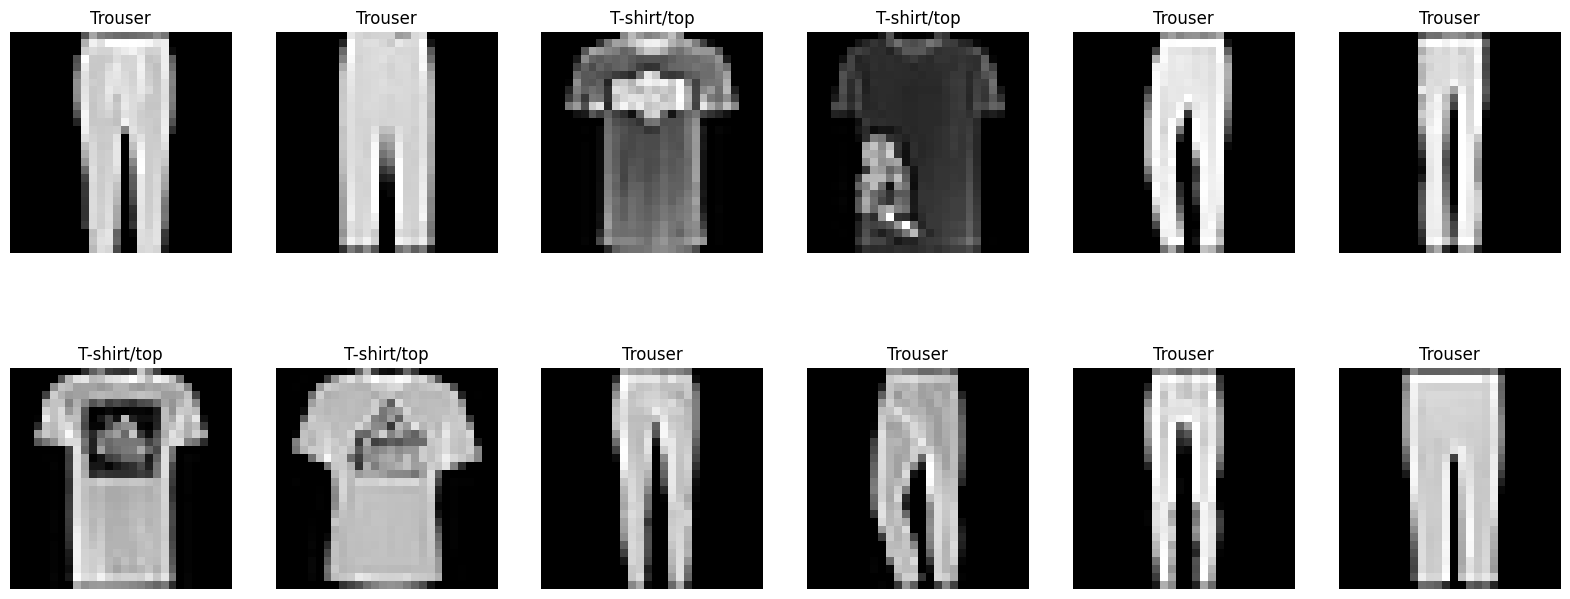

In [265]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(20, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(eval.drop("ID", axis=1).iloc[i].values.reshape(
        (28, 28)), cmap='gray')
    ax.axis('off')
    ax.set_title(things[prediction.iloc[i]])


Vypadá to, že model alespoň někdy predikuje správně.